# Library Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Exploring Fake News

In [ ]:
fake = pd.read_csv("Fake.csv")

In [ ]:
fake.head()

In [ ]:
#Counting by Subjects 
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=fake)
plt.show()

In [ ]:
#Word Cloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Exploring Real news

In [6]:
real = pd.read_csv("True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Difference in Text
Real news seems to have source of publication which is not present in fake news set

Looking at the data:
- most of text contains reuters information such as "**WASHINGTON (Reuters)**".
- Some text are tweets from Twitter 
- Few text do not contain any publication info

# Cleaning Data
Removing Twitter or Reuters Tweet details from the written word

- Only once, at the "-" character that is always present after mentioning the source of publishing, can text be divided into publication part and text part.
- If the text portion is missing, publication information wasn't provided for that item.
- The source of a Twitter tweet is a lengthy text with a character limit of 259 characters.


In [ ]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [ ]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

While looking at texts that do not contain publication info such as which reuter, we noticed one thing.

**Text at index 8970 is empty**

In [8]:
real.iloc[8970]
#yep empty
#will remove this soon

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [3]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

NameError: name 'real' is not defined

In [4]:
#Replace existing text column with new text
#add seperate column for publication info
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

NameError: name 'real' is not defined

In [5]:
real.head()

NameError: name 'real' is not defined

New column called "Publisher" has been added.


In [18]:
#checking for rows with empty text like row:8970
[index for index,text in enumerate(real.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [19]:
#dropping this record
real = real.drop(8970, axis=0)

In [20]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


**630 Rows in Fake news with empty text**

Also noticed fake news have a lot of CPATIAL-CASES. Could preserve Cases of letters, but as we are using Google's pretrained word2vec vectors later on, which haswell-formed lower cases word. We will contert to lower case.

The text for these rows seems to be present in title itself. Lets merge title and text to solve these cases.

In [21]:
#Looking at publication Information
# Checking if Some part of text has been included as publisher info... No such cases it seems :)

# for name,count in real.publisher.value_counts().iteritems():
#     print(f"Name: {name}\nCount: {count}\n")

In [22]:
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects 
for key,count in real.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

Total Records:	21416
politicsNews:	11271
worldnews:	10145


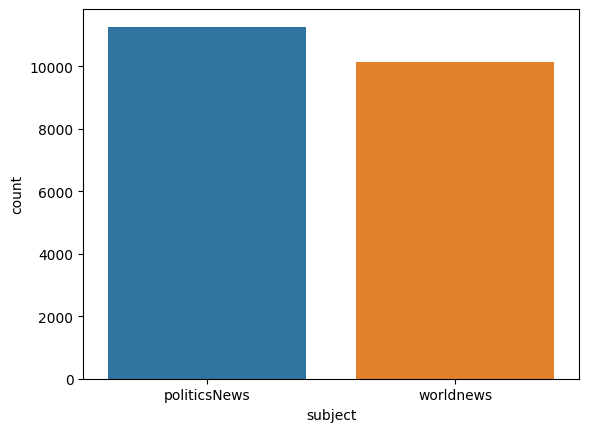

In [23]:
sns.countplot(x="subject", data=real)
plt.show()

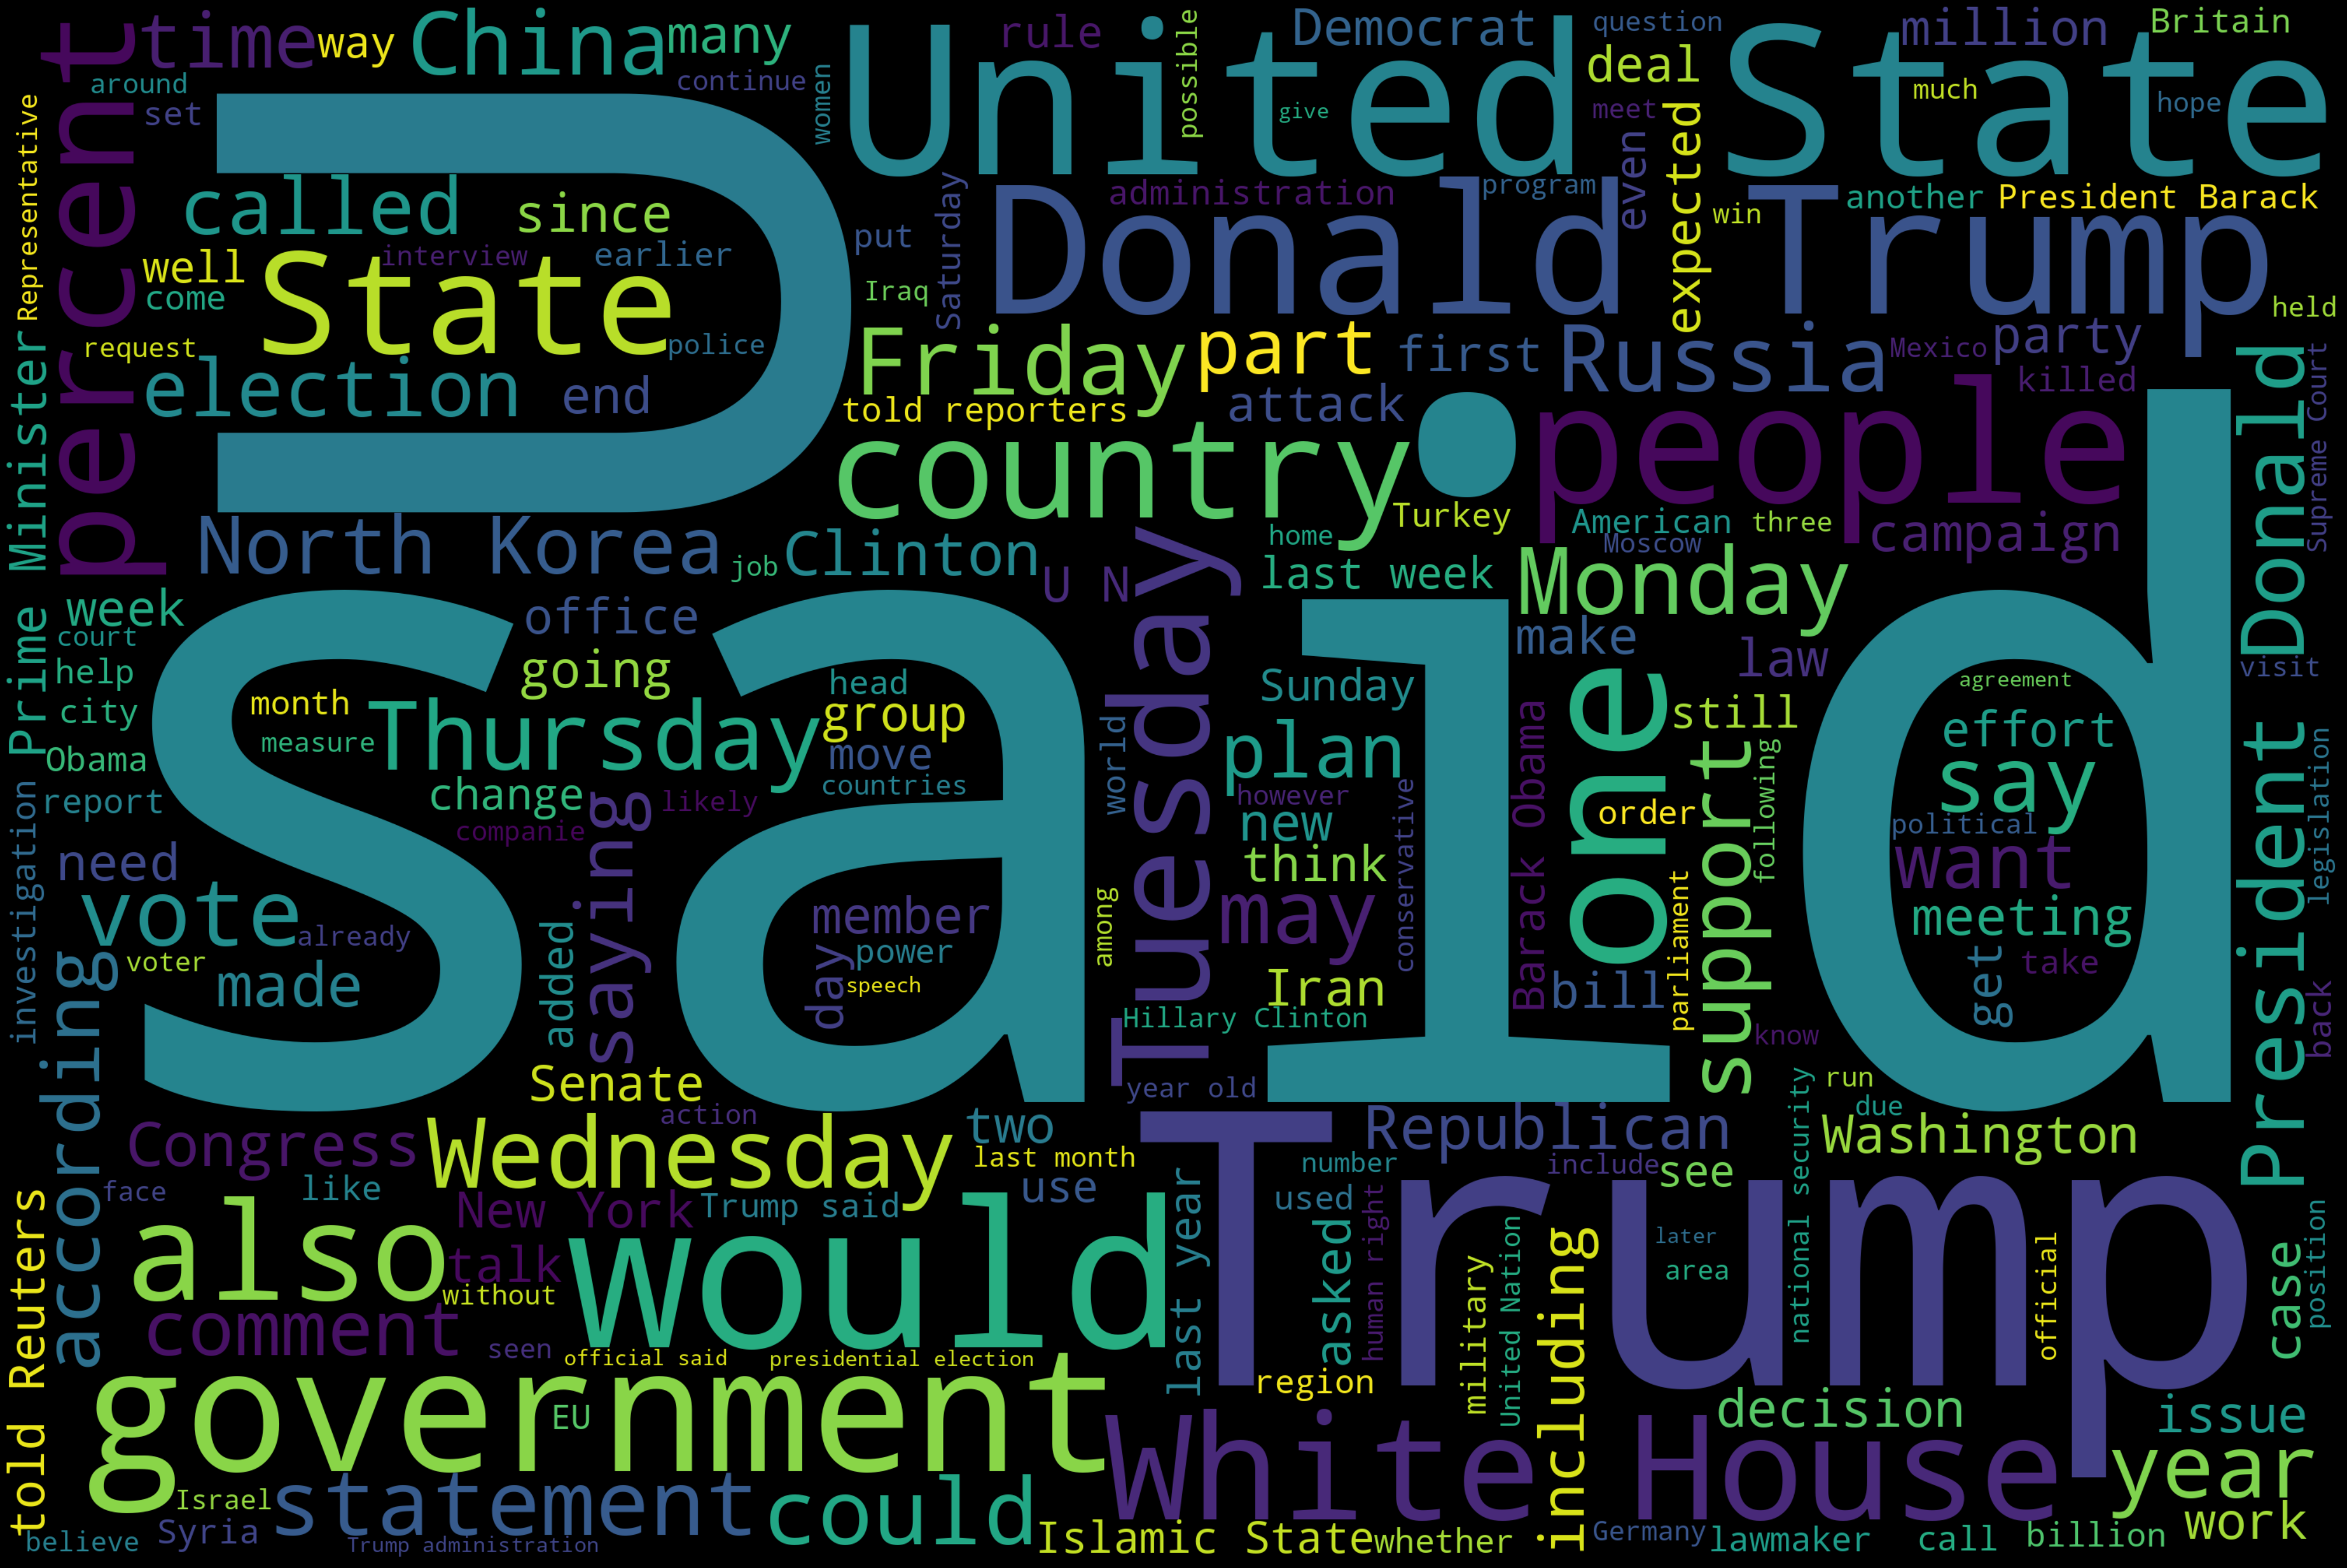

In [24]:
#WordCloud For Real News
text = ''
for news in real.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Preprocessing Text

In [25]:
# Adding class Information
real["class"] = 1
fake["class"] = 0

In [26]:
#Combining Title and Text
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [27]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [28]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)
del real, fake

Removing StopWords, Punctuations and single-character words

In [30]:
y = data["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

### Vectorization -- Word2Vec


#### Let's create and check our own Word2Vec model with **gensim**

In [32]:
import gensim

In [34]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [37]:
#vocab size
len(w2v_model.wv.key_to_index)

#We have now represented each of 122248 words by a 100dim vector.

122248

### Exploring Vectors

Lets checkout these vectors

In [39]:
#see a sample vector for random word, lets say Corona 
w2v_model.wv["corona"]

array([ 2.21339613e-02,  2.23195441e-02,  4.98224422e-02,  1.06069781e-02,
       -2.50821076e-02, -6.84499890e-02,  8.93094391e-02,  1.01552732e-01,
       -5.96229732e-02, -1.44552246e-01, -6.02039229e-03,  8.41123890e-03,
        1.50581608e-02, -2.12976336e-02,  7.38669047e-03, -2.49655396e-02,
       -5.79730272e-02, -8.17144588e-02,  2.37205718e-03, -2.55184993e-02,
       -3.99149805e-02,  2.58154739e-02, -9.71718356e-02, -7.89916068e-02,
        2.65257284e-02,  1.09473197e-02, -9.19165239e-02,  1.46766528e-02,
       -5.23840822e-02, -7.52658161e-06, -5.07786917e-03, -8.11548904e-02,
       -2.16761064e-02,  5.24189621e-02,  8.61306954e-03,  1.34573402e-02,
        5.23686595e-03, -2.75259069e-03, -7.66397417e-02, -3.42266075e-02,
       -1.80417486e-02,  3.78102474e-02, -2.63456330e-02, -7.49978237e-03,
        2.77228598e-02,  1.02445923e-01, -6.73880652e-02, -3.34229902e-03,
        1.97984773e-05,  2.49894336e-02, -3.16074900e-02, -5.76997213e-02,
       -2.17668642e-03, -

In [41]:
w2v_model.wv.most_similar("iran")

[('tehran', 0.8907957673072815),
 ('iranian', 0.7472127676010132),
 ('destabilizing', 0.6418178081512451),
 ('iranians', 0.6374207735061646),
 ('hezbollah', 0.626485288143158),
 ('irgc', 0.6205053329467773),
 ('nuclear', 0.6149604916572571),
 ('russia', 0.6058053970336914),
 ('riyadh', 0.5927020311355591),
 ('jcpoa', 0.5853034257888794)]

In [42]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.7391501665115356),
 ('cia', 0.6484460830688477),
 ('doj', 0.6243530511856079),
 ('investigators', 0.6016613245010376),
 ('investigation', 0.596809983253479),
 ('mueller', 0.5866230726242065),
 ('investigations', 0.5361046195030212),
 ('nunes', 0.5321381688117981),
 ('probe', 0.5299046039581299),
 ('inquiry', 0.522091805934906)]

In [43]:
w2v_model.wv.most_similar("facebook")

[('reddit', 0.6795897483825684),
 ('fb', 0.6608138084411621),
 ('instagram', 0.6495514512062073),
 ('google', 0.6284286379814148),
 ('gofundme', 0.6076918244361877),
 ('online', 0.5907936692237854),
 ('blog', 0.5858759880065918),
 ('posting', 0.5802536010742188),
 ('website', 0.568915843963623),
 ('hashtag', 0.5679407119750977)]

In [44]:
w2v_model.wv.most_similar("computer")

[('computers', 0.8356669545173645),
 ('software', 0.7830431461334229),
 ('electronic', 0.7754781246185303),
 ('laptop', 0.748824417591095),
 ('malware', 0.7432430386543274),
 ('servers', 0.7100204825401306),
 ('scanning', 0.7046512365341187),
 ('kaspersky', 0.7028672695159912),
 ('encrypted', 0.6933619976043701),
 ('lab', 0.6844110488891602)]

In [45]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('cruz', 0.5436536073684692),
 ('bush', 0.5404013991355896),
 ('elect', 0.5302489995956421),
 ('incoming', 0.5023669600486755),
 ('crooked', 0.4969184994697571),
 ('hillary', 0.4917161762714386),
 ('actually', 0.4656350314617157),
 ('course', 0.45765796303749084),
 ('obamahe', 0.44928982853889465),
 ('sanders', 0.44508859515190125)]

**Looking at the similar words, vectors are well formed for these words :)**


These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors. 


Keras has implementation called "**Embedding Layer**" which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.




We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number

In [46]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [47]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[389, 395, 10495, 54, 5509, 1286, 4840, 315, 205, 16]

In [48]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


**Notice it starts with 1**


We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input. 


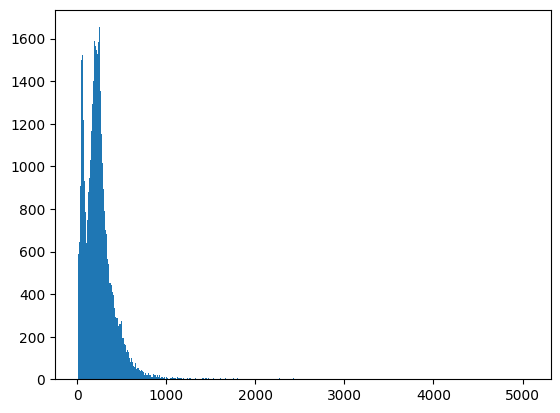

In [49]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [50]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

43982

In [51]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [52]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [53]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [57]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.


Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [101]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [102]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [103]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 700, 100)          12224900  
                                                                 
 lstm_5 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________


In [104]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [105]:
history=model.fit(X_train, y_train, validation_split=0.3, epochs=5)

Epoch 1/5
737/737 [==============================] - 384s 518ms/step - loss: 0.1274 - acc: 0.9553 - val_loss: 0.0965 - val_acc: 0.9706
Epoch 2/5
737/737 [==============================] - 380s 516ms/step - loss: 0.0834 - acc: 0.9710 - val_loss: 0.0721 - val_acc: 0.9752
Epoch 3/5
737/737 [==============================] - 372s 505ms/step - loss: 0.0460 - acc: 0.9846 - val_loss: 0.0446 - val_acc: 0.9855
Epoch 4/5
737/737 [==============================] - 372s 505ms/step - loss: 0.0245 - acc: 0.9912 - val_loss: 0.0263 - val_acc: 0.9912
Epoch 5/5
737/737 [==============================] - 372s 505ms/step - loss: 0.0212 - acc: 0.9931 - val_loss: 0.0264 - val_acc: 0.9903


In [106]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

351/351 [==============================] - 60s 170ms/step


In [12]:
accuracy_score(y_test, y_pred)

NameError: name 'accuracy_score' is not defined

In [13]:
print(classification_report(y_test, y_pred))

NameError: name 'classification_report' is not defined

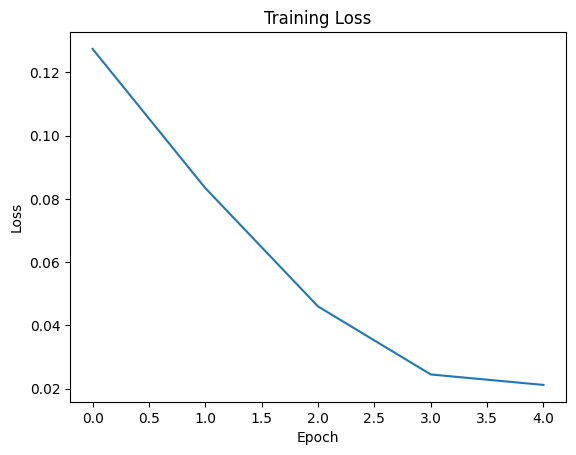

In [112]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


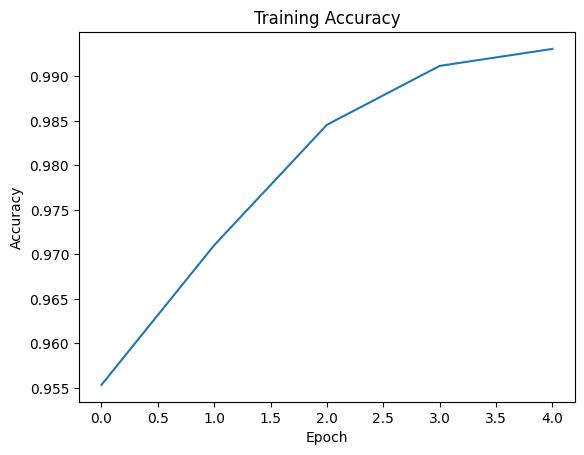

In [111]:
# Plot training accuracy
plt.plot(history.history['acc'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


### without using embedding vectors


In [113]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [114]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 700, 100)          12224900  
                                                                 
 lstm_6 (LSTM)               (None, 128)               117248    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [116]:
history=model.fit(X_train, y_train, validation_split=0.3, epochs=5)

Epoch 1/5
737/737 [==============================] - 416s 561ms/step - loss: 0.4672 - acc: 0.7756 - val_loss: 0.5037 - val_acc: 0.7327
Epoch 2/5
737/737 [==============================] - 389s 527ms/step - loss: 0.3600 - acc: 0.8360 - val_loss: 0.3358 - val_acc: 0.8470
Epoch 3/5
737/737 [==============================] - 372s 505ms/step - loss: 0.3238 - acc: 0.8549 - val_loss: 0.2688 - val_acc: 0.8851
Epoch 4/5
737/737 [==============================] - 372s 505ms/step - loss: 0.2790 - acc: 0.8845 - val_loss: 0.3819 - val_acc: 0.8283
Epoch 5/5
737/737 [==============================] - 380s 515ms/step - loss: 0.2662 - acc: 0.8877 - val_loss: 0.2184 - val_acc: 0.9182


In [117]:
accuracy_score(y_test, y_pred)

0.49879732739420934

In [2]:
print(classification_report(y_test, y_pred))

NameError: name 'classification_report' is not defined